<a href="https://colab.research.google.com/github/CharFox1/CompVisProj/blob/main/lstmCharModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn, tensor
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!unzip handwrittenChars.zip

Archive:  handwrittenChars.zip
   creating: handwrittenChars/
   creating: handwrittenChars/.ipynb_checkpoints/
  inflating: handwrittenChars/.ipynb_checkpoints/parseHandwrittenChars-checkpoint.ipynb  
  inflating: handwrittenChars/parseHandwrittenChars.ipynb  
  inflating: handwrittenChars/trainSmall.npy  
  inflating: handwrittenChars/valSmall.npy  


In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [39]:
# Manually pick cpu device if desired
device = "cpu"

In [4]:
# resnet block to be used in models below
# code modified from "resnet-34-pytorch-starter-kit"

class resBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1, bias=False):
    super(resBlock, self).__init__()
    
    self.cnn1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True)
    )

    self.cnn2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
        nn.BatchNorm2d(out_channels)
    )

    # if the output image will be a different size than the input
    # must reshape residual to fit new output shape
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels)
      )
    # otherwise just pass it through 
    else:
      self.shortcut = nn.Sequential()

  def forward(self, x):
    residual = x
    x = self.cnn1(x)
    x = self.cnn2(x)
    x += self.shortcut(residual)
    x = nn.ReLU(True)(x)
    return x

In [5]:
# small function to turn int index into one hot encoding
def oneHot(num, numClasses):
  output = [0] * numClasses
  output[num] = 1
  return output

training data size: 78000
validation data size: 13000
training data shape: (32, 32)


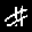

data type of image = <class 'numpy.ndarray'>
training data label: #
each index in dataset has image (32x32) and char label
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
# get conv demo data (https://www.kaggle.com/vaibhao/handwritten-characters)
from google.colab.patches import cv2_imshow #allows us to show images

# grab small files (created from larger dataset)
# this is the location they should be in the github
# if you are running in collab, you need to import the handwrittenChars folder as a zip
# you can unzip it with "!unzip handwrittenChars.zip" in a separate cell
with open("handwrittenChars/trainSmall.npy", "rb") as f:
    conv_train_data = np.load(f, allow_pickle=True)

with open("handwrittenChars/valSmall.npy", "rb") as f:
    conv_val_data = np.load(f, allow_pickle=True)

conv_val_data = conv_val_data[:13000]

print("training data size:", len(conv_train_data))
print("validation data size:", len(conv_val_data))

print("training data shape:", conv_train_data[1201][0].shape)
cv2_imshow(conv_train_data[1201][0])
print("data type of image =", type(conv_train_data[1201][0]))
print("training data label:", conv_train_data[1201][1])
print("each index in dataset has image (32x32) and char label")
print(conv_train_data[1201][0])

In [7]:
labels = []
# used for stopping prediction of recurrent layers
labels.append("<EOS>") 
for i in conv_train_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the training dataset")

for i in conv_val_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the validation dataset")

labelDict = {}
for i in range(len(labels)):
  labelDict[i] = labels[i]

print(labelDict)
invertedLabelDict = {y:x for x,y in labelDict.items()}
print(invertedLabelDict)

there are 40 labels in the training dataset
there are 40 labels in the validation dataset
{0: '<EOS>', 1: '#', 2: '$', 3: '&', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '@', 15: 'A', 16: 'B', 17: 'C', 18: 'D', 19: 'E', 20: 'F', 21: 'G', 22: 'H', 23: 'I', 24: 'J', 25: 'K', 26: 'L', 27: 'M', 28: 'N', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: 'Z'}
{'<EOS>': 0, '#': 1, '$': 2, '&': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '@': 14, 'A': 15, 'B': 16, 'C': 17, 'D': 18, 'E': 19, 'F': 20, 'G': 21, 'H': 22, 'I': 23, 'J': 24, 'K': 25, 'L': 26, 'M': 27, 'N': 28, 'P': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'W': 36, 'X': 37, 'Y': 38, 'Z': 39}


In [8]:
# dataset class
class handwrittenCharsDataset(Dataset):
    def __init__(self, X, classToNum):
      self.classToNum = classToNum
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      image = self.images[index]
      # since lstm is being used but there is always only 1 char, no need to worry about parsing label
      # just make one hot vector for char and end token and put them together in tensor
      char = self.classToNum[self.labels[index]]
      end = self.classToNum["<EOS>"]
      label = tensor([char, end])
      image = self.transform(image)
      sample = [image, label]
      return sample

    transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor()                     
    ])

In [9]:
batch_size = 10
dataset = handwrittenCharsDataset(X=conv_train_data, classToNum=invertedLabelDict)
train_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

In [10]:
def toChars(nums, dict):
  out = []
  for num in nums:
    out.append(dict[num])
  return out

In [11]:
# recurrent conv model to look at image and predict chars until all are read
# uses resnet structure

class convLSTM(nn.Module):
  def __init__(self, numClasses, batchSize, maxLen):
    super(convLSTM, self).__init__()
    self.numClasses = numClasses
    self.batchSize = batchSize
    self.maxLen = maxLen

    self.block1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=2, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )

    self.block2 = nn.Sequential(
        nn.MaxPool2d(1, 1),
        resBlock(64, 64),
        resBlock(64, 64, 2)
    )

    self.block3 = nn.Sequential(
        resBlock(64, 128),
        resBlock(128, 128, 2)
    )

    self.block4 = nn.Sequential(
        resBlock(128, 256),
        resBlock(256, 256, 2)
    )

    self.block5 = nn.Sequential(
        resBlock(256, 512),
        resBlock(512, 512, 2)
    )

    self.avgpool = nn.AvgPool2d(2)
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(512, 512)
    self.l2 = nn.Linear(512, 256)
    self.l3 = nn.Linear(256, numClasses)
    # input size, hidden size, num layers
    self.lstm = nn.LSTM(256, 256)
    # turn values to 0 with probability 0.2
    self.drop1 = nn.Dropout(0.2)
    self.drop2 = nn.Dropout(0.2)

  def forward(self, x, hidden):
    # resnet layers
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.avgpool(x)
    x = self.flatten(x)
    
    # reduce size of data and add dropout for better generalization
    x = self.l1(x)
    x = self.drop1(x)
    x = self.l2(x)
    x = self.drop2(x)
    
    # reshape image encoding so it has time dim on front
    x = x.reshape(1, self.batchSize, 256)

    #h0 = torch.zeros(1, self.batchSize, 256).to(device)
    #c0 = torch.zeros(1, self.batchSize, 256).to(device)

    x, hidden = self.lstm(x, hidden)

    # turn output to classes
    x = self.l3(x)
    return x, hidden

  def init_hidden(self):
    return (torch.zeros(1, self.batchSize, 256).to(device),
            torch.zeros(1, self.batchSize, 256).to(device))

In [12]:
def parsePred(pred):
  pred = pred.detach().cpu().numpy()
  #print(pred)
  out = []
  for i in pred:
    #print(i[0])
    out.append(labelDict[i.argmax(0).item()])

  return "".join(out)

In [13]:
# init model with 40 classes on output layer
# batch size = 10
# 2 is max chars in sequence
# put model in gpu if available
LSTMModel = convLSTM(40, 10, 2).to(device)
#print(LSTMModel)

Feature batch shape: torch.Size([10, 1, 32, 32])
Labels batch shape: torch.Size([10, 2])


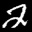

predicted 2<EOS> for 2<EOS>


In [49]:
testItem, testLabel = next(iter(train_dl))
print(f"Feature batch shape: {testItem.size()}")
print(f"Labels batch shape: {testLabel.size()}")

#testLabel = labelDict[testLabel[0].numpy().argmax()]
testLabel = testLabel.numpy()[0]

# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)

hidden = LSTMModel.init_hidden()

# predict twice with same image but different hidden
output, hidden = LSTMModel(testItem.to(device), hidden)
output2, hidden = LSTMModel(testItem.to(device), hidden)

pred1 = labelDict[output[0][0].detach().cpu().numpy().argmax(0)]
pred2 = labelDict[output2[0][0].detach().cpu().numpy().argmax(0)]

print("predicted", pred1 + pred2, "for", "".join(toChars(testLabel, labelDict)))

In [14]:
# function to find accuracy for variable size output
def findAccuracy(pred, labels):

  accuracy = 0

  #print(pred.shape)
  #print(labels.shape)

  for p, l in zip(pred, labels):
    for b in range(len(p)):
      #print(p[b])
      if p[b].argmax(0).item() == l[b]:
        accuracy += 1

  return accuracy/(pred.shape[0] * pred.shape[1])

In [15]:
# function to define loss for variable size output
# works like categorical crossentropy for each of the char predictions
def lstmLoss(pred, labels, lossFunc):
  pred = pred.permute(1,0,2)
  #print(pred.shape)
  labels = labels.permute(1,0)
  #print(labels.shape)
  loss = []
  for char, lab in zip(pred, labels):
    #print(char.shape)
    #print(lab.shape)
    loss.append(lossFunc(char, lab))
  return loss

In [32]:
import torch.optim as optim
#LSTMModel = convLSTM(40, 10, 2).to(device)

lossFunc = nn.CrossEntropyLoss()
opt = optim.SGD(LSTMModel.parameters(), lr=0.001) 

num_epochs = 5
max_len = 2
batch_size = 10

testLoss = []
testAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(train_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.permute(1,0).to(device)

    opt.zero_grad()

    hidden = LSTMModel.init_hidden()

    outputs = []
    losses = []
    for j in range(max_len):
      LSTMModel.zero_grad()
      #hidden[0].detach_()
      #hidden[1].detach_()

      #print(images.shape)
      #print(hidden[0].shape)

      output, hidden = LSTMModel(images, hidden)
      hidden = (hidden[0].detach(), hidden[1].detach())

      #print(output[0].shape)
      #print(labels[j])

      loss = lossFunc(output[0], labels[j])
      #print(loss)
      loss.backward()
      opt.step()

      outputs.append(output[0])
      losses.append(loss)

    outputs = torch.stack(outputs)
    running_acc += findAccuracy(outputs, labels)

    #print(loss)
    running_loss += sum(losses).item()
    if i % 1000 == 999:
      testLoss.append(running_loss)
      testAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 5.37488 acc: 49.430%
[1,  2000] loss: 4.43510 acc: 50.000%
[1,  3000] loss: 4.31214 acc: 50.000%
[1,  4000] loss: 4.13866 acc: 50.000%
[1,  5000] loss: 3.95189 acc: 50.000%
[1,  6000] loss: 3.77060 acc: 50.000%
[1,  7000] loss: 3.51738 acc: 50.035%
[2,  1000] loss: 2.84604 acc: 66.875%
[2,  2000] loss: 2.43004 acc: 78.225%
[2,  3000] loss: 2.05487 acc: 82.520%
[2,  4000] loss: 1.69731 acc: 86.990%
[2,  5000] loss: 1.39592 acc: 89.650%
[2,  6000] loss: 1.13518 acc: 91.645%
[2,  7000] loss: 0.94093 acc: 92.625%
[3,  1000] loss: 0.68564 acc: 94.350%
[3,  2000] loss: 0.59292 acc: 94.875%
[3,  3000] loss: 0.52551 acc: 95.225%
[3,  4000] loss: 0.48486 acc: 95.045%
[3,  5000] loss: 0.44654 acc: 95.335%
[3,  6000] loss: 0.40361 acc: 95.745%
[3,  7000] loss: 0.39045 acc: 95.475%
[4,  1000] loss: 0.32422 acc: 96.370%
[4,  2000] loss: 0.30652 acc: 96.305%
[4,  3000] loss: 0.29295 acc: 96.540%
[4,  4000] loss: 0.29371 acc: 96.400%
[4,  5000] loss: 0.27254 acc: 96.685%
[4,  6000] l

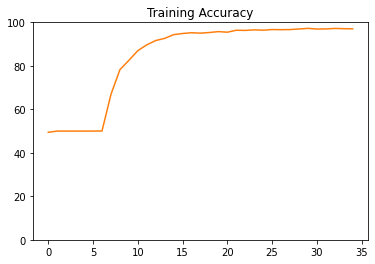

In [50]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(testAcc, color="tab:orange")
ax.set_ylim([0,100])
ax.set_title("Training Accuracy")
plt.show()

In [16]:
batch_size = 10
dataset = handwrittenCharsDataset(X=conv_val_data, classToNum=invertedLabelDict)
train_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

In [58]:
num_epochs = 3
max_len = 2
batch_size = 10

valLoss = []
valAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(train_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.permute(1,0).to(device)

    opt.zero_grad()

    hidden = LSTMModel.init_hidden()

    outputs = []
    losses = []
    for j in range(max_len):
      LSTMModel.zero_grad()
      #hidden[0].detach_()
      #hidden[1].detach_()

      #print(images.shape)
      #print(hidden[0].shape)

      output, hidden = LSTMModel(images, hidden)
      hidden = (hidden[0].detach(), hidden[1].detach())

      #print(output[0].shape)
      #print(labels[j])

      loss = lossFunc(output[0], labels[j])
      #print(loss)
      #loss.backward()
      #opt.step()

      outputs.append(output[0])
      losses.append(loss)

    outputs = torch.stack(outputs)
    running_acc += findAccuracy(outputs, labels)

    #print(loss)
    running_loss += sum(losses).item()
    if i % 1000 == 999:
      valLoss.append(running_loss)
      valAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 1.06518 acc: 88.845%
[2,  1000] loss: 1.05418 acc: 88.810%
[3,  1000] loss: 1.08221 acc: 88.585%
Done!


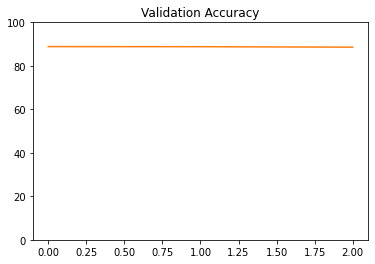

In [59]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(valAcc, color="tab:orange")
ax.set_ylim([0,100])
ax.set_title("Validation Accuracy")
plt.show()

In [17]:
# dataset class with corner detection added (may make things more difficult)
class handwrittenCharsCornerDataset(Dataset):
    def __init__(self, X, classToNum):
      self.classToNum = classToNum
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      # apply corner detection to image
      image = np.float32(self.images[index])
      image = image * cv2.cornerHarris(image, 2, 3, 0.04)

      char = self.classToNum[self.labels[index]]
      end = self.classToNum["<EOS>"]
      label = tensor([char, end])

      image = self.transform(image)
      sample = [image, label]
      return sample
    
    transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor()                     
    ])

In [18]:
batch_size = 10
dataset = handwrittenCharsCornerDataset(X=conv_train_data, classToNum=invertedLabelDict)
cornerTrain_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

In [19]:
# init model with 40 classes on output layer
# batch size = 10
# 2 is max chars in sequence
# put model in gpu if available
CornerLSTMModel = convLSTM(40, 10, 2).to(device)
#print(LSTMModel)

Feature batch shape: torch.Size([10, 1, 32, 32])
Labels batch shape: torch.Size([10, 2])


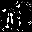

predicted XZ for W<EOS>


In [82]:
testItem, testLabel = next(iter(cornerTrain_dl))
print(f"Feature batch shape: {testItem.size()}")
print(f"Labels batch shape: {testLabel.size()}")

#testLabel = labelDict[testLabel[0].numpy().argmax()]
testLabel = testLabel.numpy()[0]

# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)

hidden = CornerLSTMModel.init_hidden()

# predict twice with same image but different hidden
output, hidden = CornerLSTMModel(testItem.to(device), hidden)
output2, hidden = CornerLSTMModel(testItem.to(device), hidden)

pred1 = labelDict[output[0][0].detach().cpu().numpy().argmax(0)]
pred2 = labelDict[output2[0][0].detach().cpu().numpy().argmax(0)]

print("predicted", pred1 + pred2, "for", "".join(toChars(testLabel, labelDict)))

In [83]:
lossFunc = nn.CrossEntropyLoss()
opt = optim.SGD(CornerLSTMModel.parameters(), lr=0.001) 

num_epochs = 5
max_len = 2
batch_size = 10

testLoss = []
testAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(cornerTrain_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.permute(1,0).to(device)

    opt.zero_grad()

    hidden = CornerLSTMModel.init_hidden()

    outputs = []
    losses = []
    for j in range(max_len):
      CornerLSTMModel.zero_grad()
      #hidden[0].detach_()
      #hidden[1].detach_()

      #print(images.shape)
      #print(hidden[0].shape)

      output, hidden = CornerLSTMModel(images, hidden)
      hidden = (hidden[0].detach(), hidden[1].detach())

      #print(output[0].shape)
      #print(labels[j])

      loss = lossFunc(output[0], labels[j])
      #print(loss)
      loss.backward()
      opt.step()

      outputs.append(output[0])
      losses.append(loss)

    outputs = torch.stack(outputs)
    running_acc += findAccuracy(outputs, labels)

    #print(loss)
    running_loss += sum(losses).item()
    if i % 1000 == 999:
      testLoss.append(running_loss)
      testAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 5.37755 acc: 48.790%
[1,  2000] loss: 4.43367 acc: 50.000%
[1,  3000] loss: 4.32828 acc: 50.000%
[1,  4000] loss: 4.21009 acc: 50.000%
[1,  5000] loss: 4.10253 acc: 50.000%
[1,  6000] loss: 3.98895 acc: 50.010%
[1,  7000] loss: 3.86689 acc: 50.020%
[2,  1000] loss: 3.61003 acc: 50.610%
[2,  2000] loss: 3.47025 acc: 51.370%
[2,  3000] loss: 3.30581 acc: 54.045%
[2,  4000] loss: 3.12624 acc: 57.480%
[2,  5000] loss: 2.91168 acc: 61.590%
[2,  6000] loss: 2.69022 acc: 64.905%
[2,  7000] loss: 2.48426 acc: 67.985%
[3,  1000] loss: 2.12148 acc: 74.185%
[3,  2000] loss: 1.95044 acc: 76.965%
[3,  3000] loss: 1.77447 acc: 80.145%
[3,  4000] loss: 1.61251 acc: 83.015%
[3,  5000] loss: 1.45986 acc: 85.080%
[3,  6000] loss: 1.29783 acc: 87.305%
[3,  7000] loss: 1.16602 acc: 89.030%
[4,  1000] loss: 0.92116 acc: 91.370%
[4,  2000] loss: 0.84466 acc: 91.955%
[4,  3000] loss: 0.75481 acc: 92.920%
[4,  4000] loss: 0.70994 acc: 92.885%
[4,  5000] loss: 0.63825 acc: 93.485%
[4,  6000] l

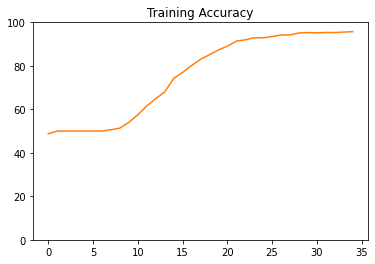

In [90]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(testAcc, color="tab:orange")
ax.set_ylim([0,100])
ax.set_title("Training Accuracy")
plt.show()

original image


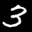

(32, 32)
corner detection


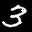

In [37]:
# experiment with effects of FAST  detection
print("original image")
input = np.float32(conv_train_data[12345][0])
#input = cv2.cvtColor(input, cv2.COLOR_GRAY2RGB)
cv2_imshow(input)
print(input.shape)
corners = cv2.goodFeaturesToTrack(input,25,0.01,10)
corners = np.int0(corners)

for i in corners:
  x,y = i.ravel()
  cv2.circle(input, (x,y), 1, 255, -1)

print("corner detection")
cv2_imshow(input)